In [161]:
from __future__ import print_function
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import numpy as np
import pandas as pd

from rocket import Rocket



In [2]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        d = 16
        self.fc1 = nn.Linear(5, d)
        self.fc2 = nn.Linear(d, d)
        self.fc3 = nn.Linear(d, d)
        self.fc4 = nn.Linear(d, 2)
        
        a = (12/(5+d))**0.5
        nn.init.uniform_(self.fc1.weight, a=-a, b=a)
        
        a = (12/(d+d))**0.5
        nn.init.uniform_(self.fc2.weight, a=-a, b=a)
        
        a = (12/(d+d))**0.5
        nn.init.uniform_(self.fc3.weight, a=-a, b=a)
        
        a = (6/(d+2))**0.5
        nn.init.uniform_(self.fc4.weight, a=-a, b=a)
        
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.tanh(self.fc3(x))
        
        return x
    
    

In [3]:
net = Net()

In [4]:
print(net)

Net(
  (fc1): Linear(in_features=5, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)


In [5]:
params = list(net.parameters())

In [6]:
params;

In [7]:
sum(p.numel() for p in net.parameters() if p.requires_grad)

1314

In [8]:
class MyDataset(data.Dataset):
    
    def __init__(self, state_csv, control_csv, transform=None):
        
        df_s = pd.read_csv(state_csv)
        df_c = pd.read_csv(control_csv)
        
        #normalize by (df-mean)/std
        self.s_mean, self.s_std = df_s.mean(), df_s.std()
        #self.c_mean, self.c_std = df_c.mean(), df_c.std()
        
        n_df_s = (df_s - df_s.mean())/df_s.std()
        #n_df_c = (df_c - df_c.mean())/df_c.std()
        
        #normalize control range from -1 to 1
        #self.c_max = n_df_c.max()
        #self.c_min = n_df_c.min()
        
        #n2_df_c = 2*(n_df_c-n_df_c.min())/(n_df_c.max()-n_df_c.min()) - 1
        n_df_c = df_c
        n_df_c['0'] = 2*n_df_c['0']-1 #from [0,1] to [-1,1]
        n_df_c['1'] = 2*n_df_c['1']/np.pi #from [-pi/2, pi/2] to [-1,1]
        
        
        self.df_s = torch.FloatTensor(n_df_s.values)
        self.df_c = torch.FloatTensor(n_df_c.values)
        
        self.length = len(df_s)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        
        sample = {'s': self.df_s[index], 'c': self.df_c[index]}
        
        return sample
    
    def normalize_s(self, state):
        return ((state[i] - self.s_mean[i])/self.s_std[i] for i in range(5))
    
    def normalize_c(self, control):
        
        raise NotImplementedError
        
        #return ((control[i] - self.c_mean[i])/self.c_std[i] for i in range(2))
    
    def denormalize_c(self, nn_c):
        #undo the min max
        
        #n_c = [0.5*(nn_c[i]+1)*(self.c_max[i]-self.c_min[i]) + self.c_min[i] for i in range(2)]
        
        #undo the std and mean
        #c = (n_c[i]*self.c_std[i] + self.c_mean[i] for i in range(2))
        
        c1 = (nn_c[0] + 1)/2
        c2 = (nn_c[1]*np.pi/2)
        
        return c1, c2
        

In [41]:
path_s = 'data_apollo/df_s_full.csv'
path_c = 'data_apollo/df_c_full.csv'
full_data = MyDataset(path_s, path_c)

In [14]:
train_size = int(0.95 * len(full_data))
val_size = len(full_data) - train_size
train_dataset, validate_dataset = torch.utils.data.random_split(full_data, [train_size, val_size])

In [16]:
batch_size = 8
train_dl = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dl = data.DataLoader(validate_dataset, batch_size=batch_size, shuffle=True)

In [17]:
train_dl

In [18]:
validate_dl

In [166]:

def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [167]:
net.zero_grad()

In [168]:

optimizer = optim.SGD(net.parameters(), lr = 0.05, momentum=0.9)
criterion = nn.MSELoss()


train_step = make_train_step(model=net, loss_fn=criterion, optimizer=optimizer)
losses = []
val_losses = []

n_epochs = 50

In [170]:

for epoch in range(n_epochs):
    
    for batch in train_dl:

        state = batch['s']
        control = batch['c']
        
        loss = train_step(state, control)
        
        losses.append(loss)
        
    with torch.no_grad():
        for batch in validate_dl:
            
            net.eval()
            
            state = batch['s']
            control = batch['c']

            c_hat = net(state)
            
            val_loss = criterion(control, c_hat)
            
            val_losses.append(val_loss.item())
    print(f'Epoch: {epoch}, Loss: {sum(losses)/len(losses):.6f}, Val_loss: {sum(val_losses)/len(val_losses):.6f}')


Epoch: 0, Loss: 0.007308, Val_loss: 0.007536
Epoch: 1, Loss: 0.007306, Val_loss: 0.007510
Epoch: 2, Loss: 0.007305, Val_loss: 0.007483
Epoch: 3, Loss: 0.007302, Val_loss: 0.007477
Epoch: 4, Loss: 0.007300, Val_loss: 0.007466
Epoch: 5, Loss: 0.007298, Val_loss: 0.007460
Epoch: 6, Loss: 0.007296, Val_loss: 0.007456
Epoch: 7, Loss: 0.007295, Val_loss: 0.007449
Epoch: 8, Loss: 0.007293, Val_loss: 0.007443
Epoch: 9, Loss: 0.007291, Val_loss: 0.007448


In [171]:
r = Rocket()

In [172]:
print(r)

Rocket 
Initial State: (-197.26948840771695, 981.7765838647981, -2.3520346028304395, -26.54899812060561, 8762.357349616028)


In [173]:
r.lunar_guidance_live(h_ratio=2)

In [176]:
with torch.no_grad():
    def simulate_net(rocket, model, dataset):

        t = [0,]
        dt = 1

        x, z, vx, vz, m = ([s,] for s in rocket.s_0)

        u1, u2 = [], []

        while z[-1] > 0 and t[-1] < 300:
            sf = (x[-1], z[-1], vx[-1], vz[-1], m[-1])
            
            
            #evaluate the model
            n_sf = tuple(list(dataset.normalize_s(sf)))
            
            n_uf = tuple(model(torch.FloatTensor(n_sf)).detach().numpy())
            
            uf = tuple(list(dataset.denormalize_c(n_uf)))
            

            new_state = rocket.propagate(sf, uf, dt=dt)

            x.append(new_state[0])
            z.append(new_state[1])
            vx.append(new_state[2])
            vz.append(new_state[3])
            m.append(new_state[4])
            t.append(t[-1]+dt)

            u1.append(uf[0])
            u2.append(uf[1])


            #print(f't: {t[-1]:.1f}, x:{x[-1]:.1f}, z:{z[-1]:.1f}, u1:{u1[-1]:.2f}, u2:{u2[-1]:.2f}')
        
        u1.append(u1[-1])
        u2.append(u2[-1])    
            
        return (t, x, z, vx, vz, m, u1, u2)

def simulate_no_thrust(rocket):

    t = [0,]
    dt = 1

    x, z, vx, vz, m = ([s,] for s in rocket.s_0)

    u1, u2 = [], []

    while z[-1] > 0 and t[-1] < 300:
        sf = (x[-1], z[-1], vx[-1], vz[-1], m[-1])

        new_state = rocket.propagate(sf, (0,0), dt=dt)

        x.append(new_state[0])
        z.append(new_state[1])
        vx.append(new_state[2])
        vz.append(new_state[3])
        m.append(new_state[4])
        t.append(t[-1]+dt)

        u1.append(0)
        u2.append(0)


        #print(f't: {t[-1]:.1f}, x:{x[-1]:.1f}, z:{z[-1]:.1f}, u1:{u1[-1]:.2f}, u2:{u2[-1]:.2f}')
    
    u1.append(u1[-1])
    u2.append(u2[-1])   

    return (t, x, z, vx, vz, m, u1, u2)    
        

In [177]:
with torch.no_grad():
    (t_net, x_net, z_net, vx_net, vz_net, m_net, u1_net, u2_net) = simulate_net(r, net, full_data)

t: 1.0, x:-199.6, z:955.2, u1:0.33, u2:0.00
t: 2.0, x:-202.0, z:928.7, u1:0.33, u2:0.00
t: 3.0, x:-204.3, z:902.3, u1:0.33, u2:0.00
t: 4.0, x:-206.6, z:875.9, u1:0.34, u2:0.00
t: 5.0, x:-208.9, z:849.6, u1:0.34, u2:0.01
t: 6.0, x:-211.3, z:823.3, u1:0.34, u2:0.01
t: 7.0, x:-213.6, z:797.2, u1:0.34, u2:0.01
t: 8.0, x:-215.9, z:771.1, u1:0.34, u2:0.01
t: 9.0, x:-218.1, z:745.1, u1:0.34, u2:0.01
t: 10.0, x:-220.4, z:719.2, u1:0.35, u2:0.01
t: 11.0, x:-222.7, z:693.5, u1:0.35, u2:0.01
t: 12.0, x:-224.9, z:667.8, u1:0.35, u2:0.01
t: 13.0, x:-227.1, z:642.4, u1:0.36, u2:0.01
t: 14.0, x:-229.4, z:617.1, u1:0.36, u2:0.01
t: 15.0, x:-231.6, z:592.0, u1:0.36, u2:0.01
t: 16.0, x:-233.7, z:567.1, u1:0.36, u2:0.01
t: 17.0, x:-235.9, z:542.4, u1:0.35, u2:0.01
t: 18.0, x:-238.1, z:517.9, u1:0.35, u2:0.01
t: 19.0, x:-240.2, z:493.5, u1:0.35, u2:0.01
t: 20.0, x:-242.4, z:469.2, u1:0.34, u2:0.01
t: 21.0, x:-244.5, z:445.0, u1:0.34, u2:0.01
t: 22.0, x:-246.6, z:421.0, u1:0.34, u2:0.01
t: 23.0, x:-248.7, 

In [178]:
(t_no, x_no, z_no, vx_no, vz_no, m_no, u1_no, u2_no) = simulate_no_thrust(r)

t: 1.0, x:-199.6, z:955.2, u1:0.00, u2:0.00
t: 2.0, x:-202.0, z:927.1, u1:0.00, u2:0.00
t: 3.0, x:-204.3, z:897.3, u1:0.00, u2:0.00
t: 4.0, x:-206.7, z:865.8, u1:0.00, u2:0.00
t: 5.0, x:-209.0, z:832.8, u1:0.00, u2:0.00
t: 6.0, x:-211.4, z:798.1, u1:0.00, u2:0.00
t: 7.0, x:-213.7, z:761.9, u1:0.00, u2:0.00
t: 8.0, x:-216.1, z:723.9, u1:0.00, u2:0.00
t: 9.0, x:-218.4, z:684.4, u1:0.00, u2:0.00
t: 10.0, x:-220.8, z:643.3, u1:0.00, u2:0.00
t: 11.0, x:-223.1, z:600.5, u1:0.00, u2:0.00
t: 12.0, x:-225.5, z:556.1, u1:0.00, u2:0.00
t: 13.0, x:-227.8, z:510.1, u1:0.00, u2:0.00
t: 14.0, x:-230.2, z:462.4, u1:0.00, u2:0.00
t: 15.0, x:-232.6, z:413.1, u1:0.00, u2:0.00
t: 16.0, x:-234.9, z:362.2, u1:0.00, u2:0.00
t: 17.0, x:-237.3, z:309.7, u1:0.00, u2:0.00
t: 18.0, x:-239.6, z:255.6, u1:0.00, u2:0.00
t: 19.0, x:-242.0, z:199.8, u1:0.00, u2:0.00
t: 20.0, x:-244.3, z:142.4, u1:0.00, u2:0.00
t: 21.0, x:-246.7, z:83.4, u1:0.00, u2:0.00
t: 22.0, x:-249.0, z:22.8, u1:0.00, u2:0.00
t: 23.0, x:-251.4, z:

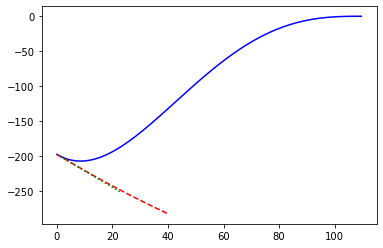

In [179]:
plt.plot(r.t, r.x, 'b-')
plt.plot(t_net, x_net, 'r--')
plt.plot(t_no, x_no, 'g:')


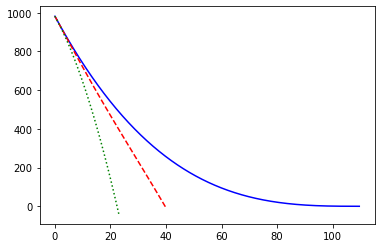

In [180]:
plt.plot(r.t, r.z, 'b-')
plt.plot(t_net, z_net, 'r--')
plt.plot(t_no, z_no, 'g:')

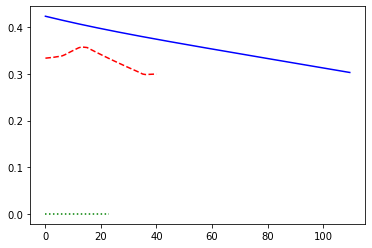

In [181]:
plt.plot(r.t, r.u1_mag, 'b-')
plt.plot(t_net, u1_net, 'r--')
plt.plot(t_no, u1_no, 'g:')

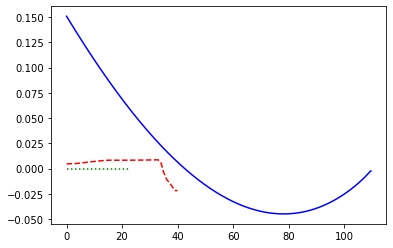

In [182]:
plt.plot(r.t, r.u2_angle, 'b-')
plt.plot(t_net, u2_net, 'r--')
plt.plot(t_no, u2_no, 'g:')

In [183]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

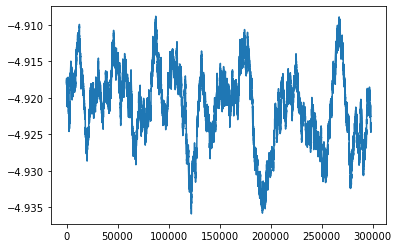

In [184]:
plt.plot(np.log(moving_average(losses[50000:],10000)))

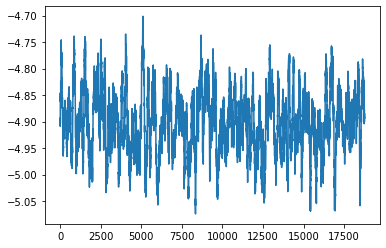

In [185]:
plt.plot(np.log(moving_average(val_losses,100)))

In [156]:
net(train_dataset[0]['s'])

tensor([-0.3531,  0.0010], grad_fn=<TanhBackward>)

In [157]:
train_dataset[0]['c']

tensor([-0.0317, -0.0134])

In [158]:
for i in range(10):
    print(net(train_dataset[i]['s']), train_dataset[i]['c'])

tensor([-0.3531,  0.0010], grad_fn=<TanhBackward>) tensor([-0.0317, -0.0134])
tensor([-0.3195,  0.0044], grad_fn=<TanhBackward>) tensor([-0.2105, -0.0155])
tensor([-0.2444,  0.0020], grad_fn=<TanhBackward>) tensor([-0.2016, -0.0052])
tensor([-0.2966,  0.0025], grad_fn=<TanhBackward>) tensor([-0.2605,  0.0083])
tensor([-0.2547,  0.0050], grad_fn=<TanhBackward>) tensor([-0.4047, -0.0114])
tensor([-0.2873,  0.0047], grad_fn=<TanhBackward>) tensor([-0.2904, -0.0082])
tensor([-0.2714,  0.0036], grad_fn=<TanhBackward>) tensor([-0.2429, -0.0086])
tensor([-0.2759,  0.0069], grad_fn=<TanhBackward>) tensor([-4.1131e-01, -1.4186e-04])
tensor([-0.2922,  0.0021], grad_fn=<TanhBackward>) tensor([-4.1753e-01, -2.3320e-04])
tensor([-0.2802,  0.0024], grad_fn=<TanhBackward>) tensor([-3.1553e-01, -3.1385e-05])


In [159]:
loss

0.007749239448457956

In [160]:
val_loss

tensor(0.0049)